# Data download and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["DARTS_CONFIGURE_MATPLOTLIB"] = "0"

from lib.constants import *

## Read data

In [2]:
prices_daily = pd.read_parquet('lib/data/apple_daily.parquet')
prices_daily.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2010-01-04 00:00:00+00:00,214.01,214.50,212.38,213.43,17633200,6.431808,6.446534,6.382820,6.414376,493730093,0.0,1.0
2010-01-05 00:00:00+00:00,214.38,215.59,213.25,214.60,21496600,6.442927,6.479292,6.408967,6.449539,601905401,0.0,1.0
2010-01-06 00:00:00+00:00,210.97,215.23,210.75,214.38,19720000,6.340444,6.468473,6.333832,6.442927,552160552,0.0,1.0
2010-01-07 00:00:00+00:00,210.58,212.00,209.05,211.75,17040400,6.328723,6.371399,6.282741,6.363886,477131677,0.0,1.0
2010-01-08 00:00:00+00:00,211.98,212.00,209.06,210.30,15986100,6.370798,6.371399,6.283041,6.320308,447611247,0.0,1.0


## Data preprocessing

In [ ]:
ts_daily = prices_daily[['adjClose']].copy()
ts_daily = ts_daily.tz_localize(None)
print(type(ts_daily.index))
ts_daily

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,adjClose
date,
2010-01-04,6.431808
2010-01-05,6.442927
2010-01-06,6.340444
2010-01-07,6.328723
2010-01-08,6.370798
...,...
2025-06-24,200.300000
2025-06-25,201.560000
2025-06-26,201.000000


Preprocessing

In [ ]:
import lib.preprocessing.wavelets as wavelets

ts_daily['denoised'] = wavelets.wavelet_denoise_series(ts_daily["adjClose"], wavelet='coif3', level=1)
ts_daily['noise'] = ts_daily["adjClose"] - ts_daily['denoised']

Signal-to-Noise Ratio (SNR): 42.92 dB


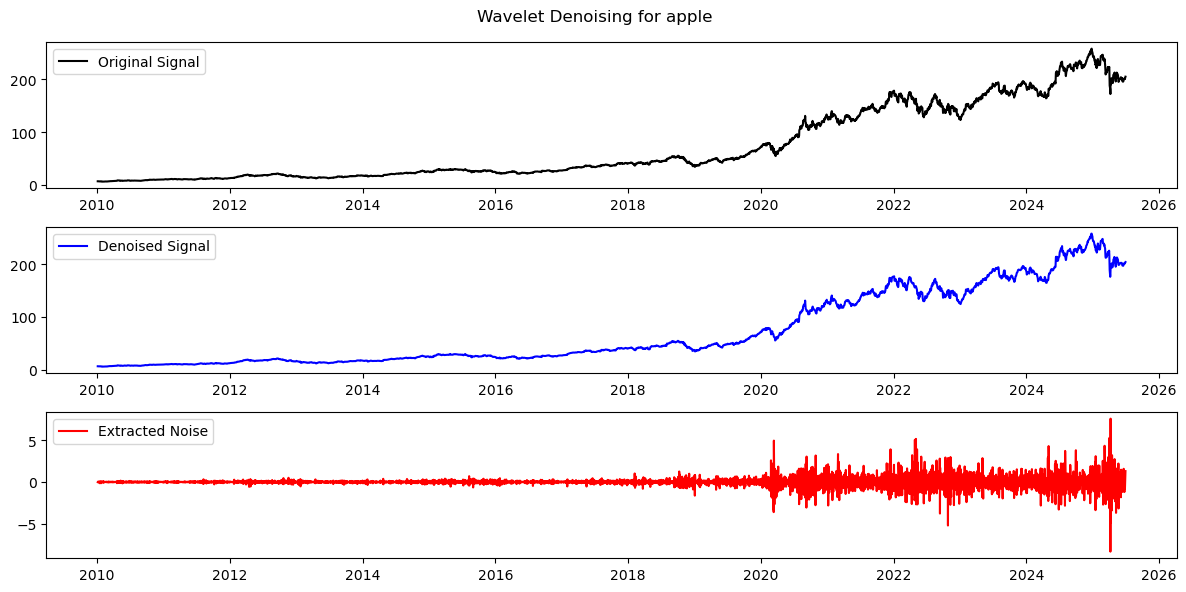

In [ ]:
wavelets.plot_wavelet_denoising(ts_daily, "apple")

In [7]:
from darts import TimeSeries

values = ts_daily["denoised"].values.reshape(-1, 1)
index = ts_daily.index

series = TimeSeries.from_values(values)

In [8]:
from darts import TimeSeries
from darts.dataprocessing.transformers import InvertibleMapper, Scaler, Diff
from darts.dataprocessing.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import numpy as np

log_mapper = InvertibleMapper(
    fn=np.log10,
    inverse_fn=lambda x: np.power(10, x),
    name="Log"
)

diff = Diff(lags=1)

# scaler = Scaler(MinMaxScaler(feature_range=(-1, 1)))

log_return = Pipeline([log_mapper]) # diff

series_prepared = log_return.fit_transform(series)
series_original = log_return.inverse_transform(series_prepared)


3896

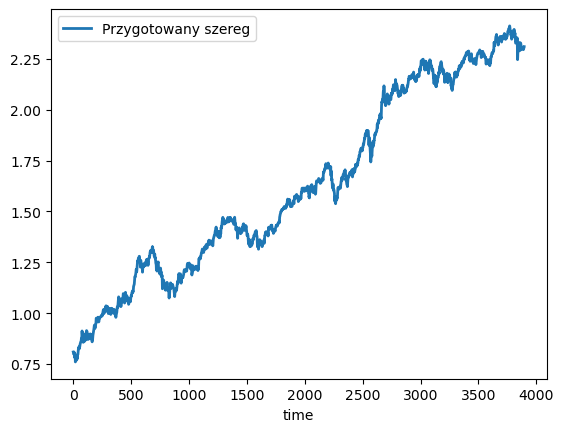

In [9]:
series_prepared.plot(label="Przygotowany szereg")
len(series_prepared)

3896

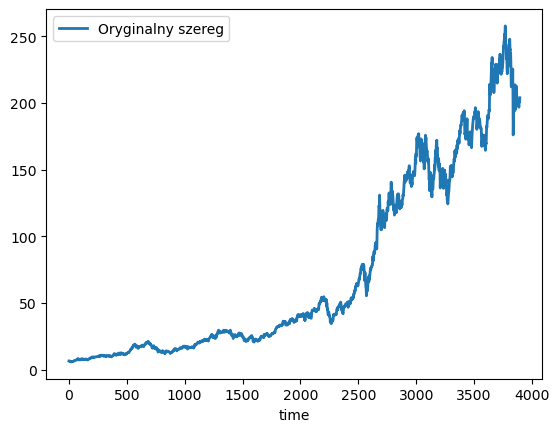

In [10]:
series_original.plot(label="Oryginalny szereg")
len(series_original)

In [11]:
from darts.utils.statistics import stationarity_test_adf

stationarity_test_adf(series_prepared)

(np.float64(-1.1661442916622535),
 np.float64(0.68798746191987),
 27,
 3868,
 {'1%': np.float64(-3.4320417386296875),
  '5%': np.float64(-2.8622875173988525),
  '10%': np.float64(-2.5671679126719487)},
 np.float64(-36555.174807967225))

ADF test results show that the series is stationary because the p-value is less than 0.05. This means that the null hypothesis of the ADF test (which states that the time series has a unit root and is non-stationary) can be rejected.

## Baseline models

### Auto ARIMA

In [12]:
import os
os.environ["DARTS_CONFIGURE_MATPLOTLIB"] = "0"

import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
import statsforecast
from darts.models import AutoARIMA
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

/home/piotrek/miniconda3/envs/mgr1/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [13]:
test_len = 100
full_len = len(series_prepared)
train, test = series_prepared.split_before(full_len - test_len)
print(len(train))

model = AutoARIMA()
model.fit(train)

3796


AutoARIMA(add_encoders=None, quantiles=None, random_state=None)

In [14]:
from statsforecast.arima import ARIMASummary
print(ARIMASummary(model.model.model_).summary())

ARIMA(5,1,2) with drift        

Coefficients:
               ar1    ar2    ar3    ar4    ar5    ma1    ma2  drift
coefficient  0.369 -0.576  0.339 -0.222  0.102  1.694  0.802  0.000
s.e.         0.025  0.021  0.021  0.017  0.016  0.016  0.016  0.016

sigma^2 = 0.0: log likelihood = 18017.60

AIC=-36017.19
None


In [15]:
forecast = model.historical_forecasts(
    test, 
    forecast_horizon=1,
    retrain=False,
    last_points_only=True,
    verbose=True,
    start=len(train)+70,
)

historical forecasts:   0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
forecast_inversed_f = log_return.inverse_transform(forecast)
f = forecast_inversed_f.to_dataframe()
f.columns = ["adjClose"]
f.index = index[-30:]

In [16]:
# series_concat_f = series_prepared[:-30].append(forecast)
# series_inversed_f = log_return.inverse_transform(series_concat_f)
# f = series_inversed_f[-30:].to_dataframe()
# f.columns = ["adjClose"]
# f.index = index[-30:]

In [17]:
f.head()

,adjClose
date,
2025-05-16,211.922179
2025-05-19,209.477124
2025-05-20,207.743896
2025-05-21,204.385984
2025-05-22,198.694131


In [18]:
# series_concat_t = series_prepared[:-30].append(test[-30:])
# series_inversed_t = log_return.inverse_transform(series_concat_t)
# t = series_inversed_t[-30:].to_dataframe()
# t.columns = ["adjClose"]
# t.index = index[-30:]

In [18]:
series_t = log_return.inverse_transform(test[-30:])
t = series_t.to_dataframe()
t.columns = ["adjClose"]
t.index = index[-30:]

In [19]:
t.head()

,adjClose
date,
2025-05-16,210.744419
2025-05-19,209.012089
2025-05-20,206.654309
2025-05-21,202.662169
2025-05-22,199.148956


In [20]:
oryginal = ts_daily[-30:]

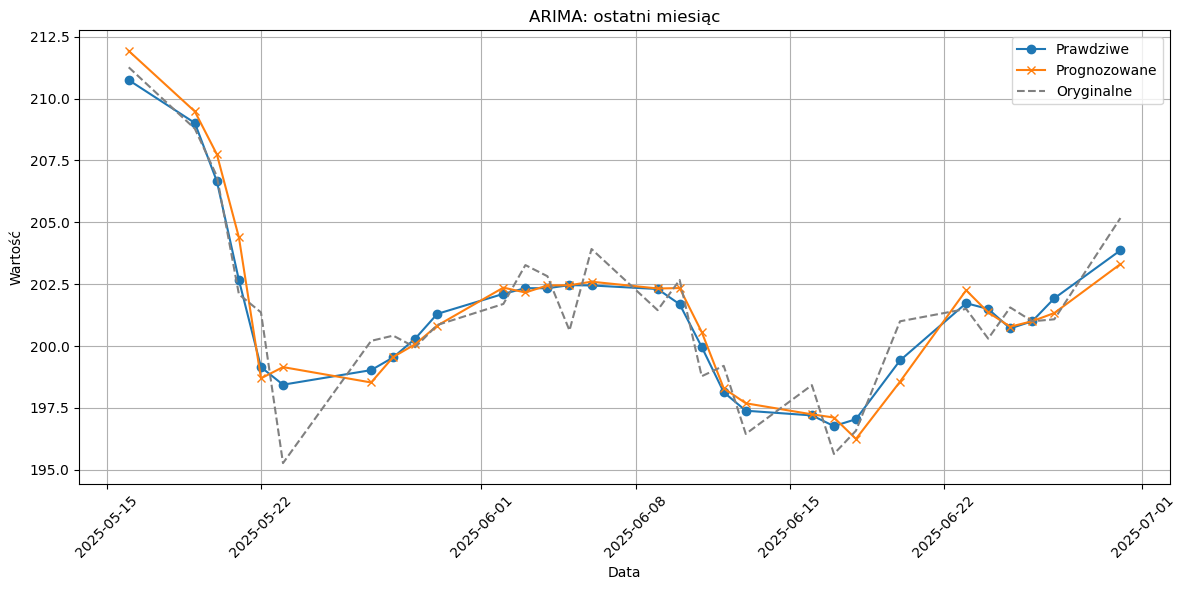

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(t.index, t["adjClose"], label="Prawdziwe", marker='o')
plt.plot(f.index, f["adjClose"], label="Prognozowane", marker='x')
plt.plot(oryginal.index, oryginal["adjClose"], label="Oryginalne", linestyle='--', color='gray')
plt.title("ARIMA: ostatni miesiąc")
plt.xlabel("Data")
plt.ylabel("Wartość")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Directional Movement Metrics
Directional Accuracy: 0.7667
Precision (Rise): 0.7333
Precision (Fall): 0.8000
Recall: 0.7857
F1 Score: 0.7586


Text(0.5, 1.0, 'Macierz pomyłek kierunku ruchu (ARIMA)')

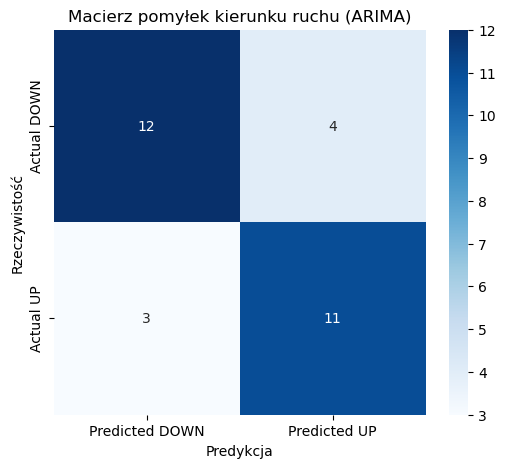

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Kierunkowe etykiety: 1 = wzrost, 0 = spadek lub brak zmiany
def direction_labels(values):
    return np.where(np.diff(values, prepend=values[0]) >= 0, 1, 0)

true_dir = direction_labels(t.adjClose.values)
pred_dir = direction_labels(f.adjClose.values)

# 2. Oblicz metryki
accuracy = accuracy_score(true_dir, pred_dir)
precision_rise = precision_score(true_dir, pred_dir, pos_label=1)
precision_fall = precision_score(true_dir, pred_dir, pos_label=0)
recall = recall_score(true_dir, pred_dir)
f1 = f1_score(true_dir, pred_dir)

# 3. Macierz pomyłek
cm = confusion_matrix(true_dir, pred_dir)
cm_df = pd.DataFrame(cm, index=["Actual DOWN", "Actual UP"], columns=["Predicted DOWN", "Predicted UP"])

# 4. Wyniki
metrics = {
    "Directional Accuracy": accuracy,
    "Precision (Rise)": precision_rise,
    "Precision (Fall)": precision_fall,
    "Recall": recall,
    "F1 Score": f1
}
metrics_df = pd.DataFrame(metrics, index=["Score"])

print("Directional Movement Metrics")
for metric, score in metrics.items():
    print(f"{metric}: {score:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues", linewidths=0)
plt.grid(False)
plt.tight_layout

plt.xlabel("Predykcja")
plt.ylabel("Rzeczywistość")
plt.title("Macierz pomyłek kierunku ruchu (ARIMA)")

In [ ]:
from darts.metrics import mape, mae

mape_value = mape(test, forecast, intersect=True)
mae_value = mae(test, forecast, intersect=True)

print(f"MAE:  {mae_value:.4f}")
print(f"MAPE: {mape_value:.2f}%")

MAE:  0.0043
MAPE: 0.19%


## N-BEATS

In [24]:
series.head()

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)> Size: 40B
array([[[6.45039458]],

       [[6.40397859]],

       [[6.35123132]],

       [[6.34705645]],

       [[6.34919702]]])
Coordinates:
  * time       (time) int64 40B 0 1 2 3 4
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [258]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

test_size = 160
val_size = 500
train_size = len(series_prepared) - val_size - test_size


train, val, test = (
    series_prepared[:train_size],
    series_prepared[train_size:train_size + val_size],
    series_prepared[-test_size:],
)
print("============================")
print(f"Train size: {len(train)}")
print(f"Validation size: {len(val)}")
print(f"Test size: {len(test)}")
print(f"Total size: {len(series_prepared)}")
print("============================")

scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1e-4,
    mode="min",
)

model = NBEATSModel(
    input_chunk_length=100,
    output_chunk_length=1,
    n_epochs=40,
    random_state=42,
    batch_size=64,
    optimizer_kwargs = {
        "lr": 1e-4,
    },
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": 1,
        "callbacks": [early_stopper]
    }
)

model.fit(
    train_scaled,
    val_series=val_scaled,
    verbose=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | eval 
1 | train_criterion | MSELoss          | 0      | eval 
2 | val_criterion   | MSELoss          | 0      | eval 
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.8 M  | train
-------------------------------------------------------------
6.8 M     Trainable params
1.9 K     Non-trainable params
6.8 M     Total params
27.169    Total estimated model params size (MB)
393       Modules in train mode
3         Modules in eval mode


Train size: 3236
Validation size: 500
Test size: 160
Total size: 3896


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=100, output_chunk_length=1, n_epochs=40, random_state=42, batch_size=64, optimizer_kwargs={'lr': 0.0001}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1, 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x707b64ea1290>]})

In [259]:
forecast = model.historical_forecasts(
    test_scaled,
    forecast_horizon=1,
    retrain=False,
    last_points_only=True,
    verbose=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [260]:
# forecast_unscaled = scaler.inverse_transform(forecast)
# series_concat_f = series_prepared[:-30].append(forecast_unscaled)
# series_inversed_f = log_return.inverse_transform(series_concat_f)
# f = series_inversed_f[-30:].to_dataframe()
# f.columns = ["adjClose"]
# f.index = index[-30:]

In [261]:
forecast_unscaled = scaler.inverse_transform(forecast)
forecast_inversed_f = log_return.inverse_transform(forecast_unscaled)
f = forecast_inversed_f.to_dataframe()
f.columns = ["adjClose"]
f.index = index[-60:]

In [262]:
series_t = log_return.inverse_transform(test[-60:])
t = series_t.to_dataframe()
t.columns = ["adjClose"]
t.index = index[-60:]

In [263]:
oryginal = ts_daily[-90:]

In [225]:
f.size, t.size

(60, 60)

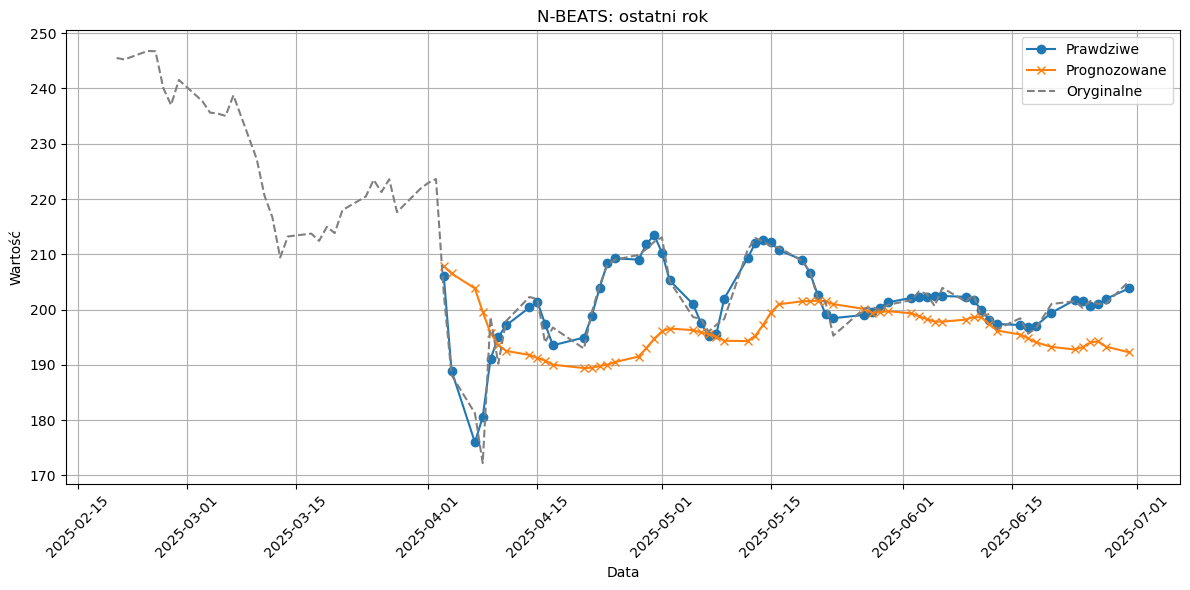

In [264]:
plt.figure(figsize=(12, 6))
plt.plot(t.index, t["adjClose"], label="Prawdziwe", marker='o')
plt.plot(f.index, f["adjClose"], label="Prognozowane", marker='x')
plt.plot(oryginal.index, oryginal["adjClose"], label="Oryginalne", linestyle='--', color='gray')
plt.title("N-BEATS: ostatni rok")
plt.xlabel("Data")
plt.ylabel("Wartość")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Directional Movement Metrics
Directional Accuracy: 0.4667
Precision (Rise): 0.5000
Precision (Fall): 0.4444
Recall: 0.3750
F1 Score: 0.4286


Text(0.5, 1.0, 'Macierz pomyłek kierunku ruchu (N-BEATS)')

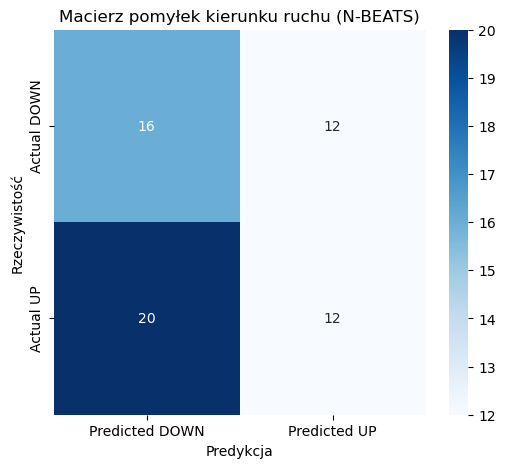

In [266]:
# 1. Kierunkowe etykiety: 1 = wzrost, 0 = spadek lub brak zmiany
def direction_labels(values):
    return np.where(np.diff(values, prepend=values[0]) >= 0, 1, 0)

true_dir = direction_labels(t.adjClose.values)
pred_dir = direction_labels(f.adjClose.values)

# 2. Oblicz metryki
accuracy = accuracy_score(true_dir, pred_dir)
precision_rise = precision_score(true_dir, pred_dir, pos_label=1)
precision_fall = precision_score(true_dir, pred_dir, pos_label=0)
recall = recall_score(true_dir, pred_dir)
f1 = f1_score(true_dir, pred_dir)

# 3. Macierz pomyłek
cm = confusion_matrix(true_dir, pred_dir)
cm_df = pd.DataFrame(cm, index=["Actual DOWN", "Actual UP"], columns=["Predicted DOWN", "Predicted UP"])

# 4. Wyniki
metrics = {
    "Directional Accuracy": accuracy,
    "Precision (Rise)": precision_rise,
    "Precision (Fall)": precision_fall,
    "Recall": recall,
    "F1 Score": f1
}
metrics_df = pd.DataFrame(metrics, index=["Score"])

print("Directional Movement Metrics")
for metric, score in metrics.items():
    print(f"{metric}: {score:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues", linewidths=0)
plt.grid(False)
plt.tight_layout

plt.xlabel("Predykcja")
plt.ylabel("Rzeczywistość")
plt.title("Macierz pomyłek kierunku ruchu (N-BEATS)")

In [93]:
from darts.metrics import mape, mae

mape_value = mape(test, forecast, intersect=True)
mae_value = mae(test, forecast, intersect=True)

print(f"MAE:  {mae_value:.4f}")
print(f"MAPE: {mape_value:.2f}%")

MAE:  0.0145
MAPE: 0.63%


# LSTM + XGBOOST

In [26]:
from darts.models import RNNModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Split data for training, validation, and testing
test_size = 100
val_size = 300
train_size = len(series_prepared) - val_size - test_size

train, val, test = (
    series_prepared[:train_size],
    series_prepared[train_size:train_size + val_size],
    series_prepared[-test_size:],
)

early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1e-4,
    mode="min",
)

lstm_model = RNNModel(
    model="LSTM",
    input_chunk_length=60,
    training_length=60,
    output_chunk_length=1,
    n_epochs=40,
    random_state=42,
    batch_size=64,
    optimizer_kwargs={"lr": 1e-3},
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": 1,
        "callbacks": [early_stopper]
    }
)

lstm_model.fit(
    train,
    val_series=val,
    verbose=True
)

lstm_forecast = lstm_model.historical_forecasts(
    test,
    forecast_horizon=1,
    retrain=False,
    last_points_only=True,
    verbose=True,
)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         Modules in train mode
0         Modul

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [28]:
forecast_inversed_f = log_return.inverse_transform(lstm_forecast)
f = forecast_inversed_f.to_dataframe()
f.columns = ["adjClose"]
f.index = index[-40:]

In [29]:
series_t = log_return.inverse_transform(test[-40:])
t = series_t.to_dataframe()
t.columns = ["adjClose"]
t.index = index[-40:]

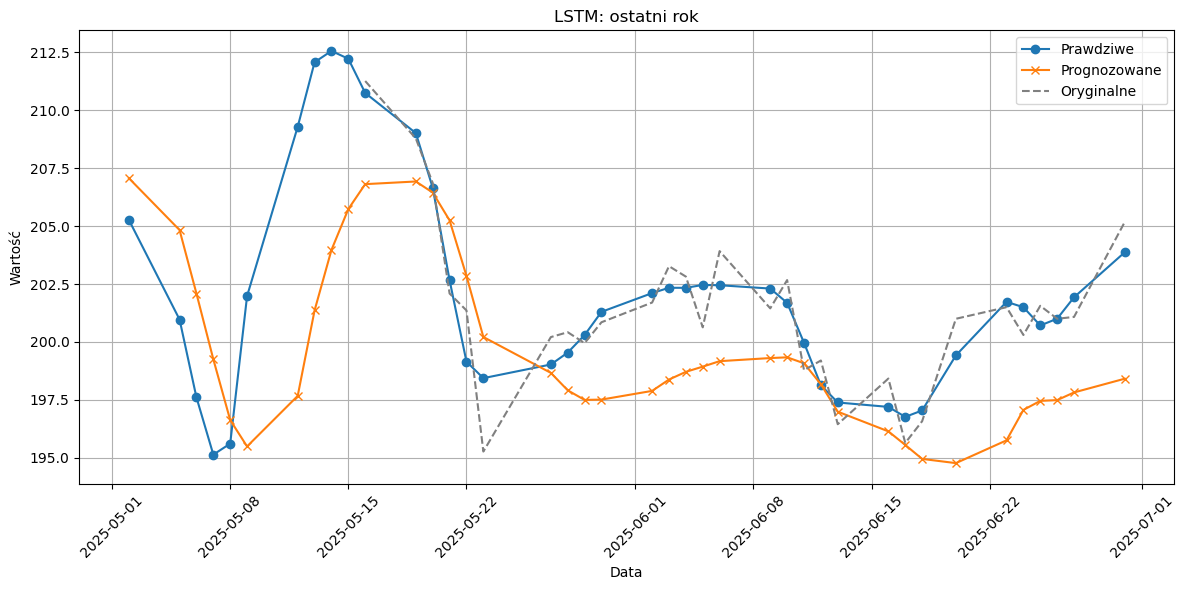

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(t.index, t["adjClose"], label="Prawdziwe", marker='o')
plt.plot(f.index, f["adjClose"], label="Prognozowane", marker='x')
plt.plot(oryginal.index, oryginal["adjClose"], label="Oryginalne", linestyle='--', color='gray')
plt.title("LSTM: ostatni rok")
plt.xlabel("Data")
plt.ylabel("Wartość")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
from darts.models import XGBModel

# Przygotuj dane wejściowe dla XGBOOST: użyj przewidywań LSTM jako cechy
# Zakładamy, że 'lstm_forecast' to TimeSeries z przewidywaniami LSTM dla testowego okresu

# XGBOOST wymaga TimeSeries jako targetu i opcjonalnie covariates (cech)
# Użyj lstm_forecast jako future_covariates, a prawdziwe wartości jako target

xgb_model = XGBModel(
    lags=10,  # liczba opóźnień, można dostosować
    output_chunk_length=1,
    random_state=42,
    lags_future_covariates=list(range(1, 11)),  # liczba opóźnień dla cech jako lista
)

# Dopasuj model na testowym zbiorze, używając lstm_forecast jako cechy
xgb_model.fit(
    test,
    future_covariates=lstm_forecast,
    verbose=True
)

# Prognozuj na tym samym okresie testowym
xgb_forecast = xgb_model.predict(
    n=len(test),
    future_covariates=lstm_forecast
)

# Odwróć transformację log_return, aby uzyskać oryginalną skalę
xgb_forecast_inversed = log_return.inverse_transform(xgb_forecast)
f_xgb = xgb_forecast_inversed.to_dataframe()
f_xgb.columns = ["adjClose"]
f_xgb.index = index[-len(test):]

f_xgb.head()

ValueError: The `future_covariates` are not long enough. Given horizon `n=100`, `min(lags_future_covariates)=1`, `max(lags_future_covariates)=10` and `output_chunk_length=1`, the `future_covariates` have to range from 3897 until 4005 (inclusive), but they only range from 3856 until 3895.


ValueError: The `future_covariates` are not long enough. Given horizon `n=100`, `min(lags_future_covariates)=1`, `max(lags_future_covariates)=10` and `output_chunk_length=1`, the `future_covariates` have to range from 3897 until 4005 (inclusive), but they only range from 3856 until 3895.